In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                       # Stats contains the ChiSquare function and its integral
from iminuit import Minuit
from iminuit.cost import LeastSquares
import os
from scipy.optimize import curve_fit

In [29]:
def peak_find(path):
    data = np.genfromtxt(path, delimiter=',', skip_header=1)
    x = data[:,0]
    y = data[:,1]
    mask = (y > 2.5) & (np.roll(y,1) < 2.5)
    x_peak = x[mask]
    return x_peak

def func(t,a,v0,x0):
    return 1/2 * a*  t**2 + v0*t + x0

def peak_fit(path,x_peak,x_err):
    elements = os.listdir(path =path)
    tset = []
    for i in range(len(elements)):
        t_temp = peak_find(path + "\\" + elements[i] )
        tset.append(t_temp)
    tset = np.array(tset)
    tmean = np.mean(tset,axis=0)
    t_err = np.std(tset,axis=0)/np.sqrt(len(elements))
    print(tmean)
    print(t_err)
    fit = LeastSquares(tmean, x_peak, x_err, func)
    fit = Minuit(fit, a = 0.1, v0 = 0.01,x0 = 0.14)
    fit.migrad()    
    fit.hesse()
    x_tot_err = np.sqrt(x_err**2 + ((fit.values[0]*tmean+fit.values[1])*t_err)**2)
    fit = LeastSquares(tmean, x_peak, x_tot_err, func)
    fit = Minuit(fit, a = 0.1, v0 = 0.01,x0 = 0.14)
    fit.migrad()    
    fit.hesse()
    display(fit)

    plt.plot(np.linspace(tmean[0],tmean[-1],100), func(np.linspace(tmean[0],tmean[-1],100), *fit.values))
    plt.errorbar(tmean, x_peak, x_tot_err, fmt='o',capsize=3)

    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.legend(['Fit','Data'])
    plt.show()


    return fit.values, fit.errors

#peak_fit('dataproject', np.array([0,0.1,0.2,0.3,0.4]), x_err= np.array([0.01]*5))

In [30]:

from IPython.core.display import Latex
import sympy as sp

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)


def g_err(am, a_err, thetam,theta_err, dthetam,dtheta_err, Dm, D_err, dm, d_err):
    np.random.seed(42)
        
    # Define variables:
    a,v,ve,D,d = sp.symbols("a, v, ve, D, d")
    da,dv,dve,dD,dd = sp.symbols("sigma_a, sigma_v, sigma_e, sigma_D, sigma_d")

    # Define relation, and print:
    P = a/(sp.sin(v + ve))*(1+ 2/5 * D**2 /(D**2 - d**2))
    lprint(sp.latex(sp.Eq(sp.symbols('P'),P)))

    # Calculate uncertainty and print:
    dP = sp.sqrt((P.diff(a) * da)**2 + (P.diff(v) * dv)**2 + (P.diff(ve) * dve)**2 + (P.diff(D) * dD)**2 + (P.diff(d) * dd)**2)
    lprint(sp.latex(sp.Eq(sp.symbols('sigma_P'), dP)))

    # Each term in the uncertainty expression
    ua = sp.lambdify((a,v,ve,D,d,da),P.diff(a) * da,)
    uv = sp.lambdify((a,v,ve,D,d,dv),P.diff(v) * dv)
    uve = sp.lambdify((a,v,ve,D,d,dve),P.diff(ve) * dve)
    uD = sp.lambdify((a,v,ve,D,d,dD),P.diff(D) * dD)
    ud = sp.lambdify((a,v,ve,D,d,dd),P.diff(d) * dd)
    print('a ',ua(am,thetam,dthetam,Dm,dm,a_err))
    print('v ',uv(am,thetam,dthetam,Dm,dm,theta_err))
    print('ve ',uve(am,thetam,dthetam,Dm,dm,dtheta_err))
    print('D ',uD(am,thetam,dthetam,Dm,dm,D_err))
    print('d ',ud(am,thetam,dthetam,Dm,dm,d_err))



    # Turn expression into numerical functions 
    fP = sp.lambdify((a,v,ve,D,d),P)
    fdP = sp.lambdify((a,da,v,dv,ve,dve,D,dD,d,dd),dP)

    # Define values and their errors

    # Numerically evaluate expressions and print 
    vP = fP(am,thetam,dthetam,Dm,dm) #+ np.random.randn()
    vdP = fdP(am,a_err,thetam,theta_err,dthetam,dtheta_err,Dm,D_err,dm,d_err)
    lprint(fr'P = ({vP:.2f} \pm {vdP:.2f})\,\mathrm{{\frac{{m}}{{s^2}}}}')



    return vP, vdP



def delta_theta_err(aim, ai_err,arm, ar_err, thetam,theta_err):
    np.random.seed(42)
    print(type(aim),type(ai_err),type(arm),type(ar_err),type(thetam),type(theta_err))
    # Define variables:
    i,r,v = sp.symbols("i,r, v")
    dai,dar,dv = sp.symbols("sigma_i, sigma_r, sigma_v")
    display(i,r,v,dai,dar,dv)
    # Perimeter:
    # Define relation, and print:
    P = sp.simplify((r-i)*sp.sin(v+0)/((i+r)*sp.cos(v+0)))
    lprint(sp.latex(sp.Eq(sp.symbols('P'),P)))

    # Calculate uncertainty and print:
    dP = sp.sqrt((P.diff(i) * dai)**2 + (P.diff(r) * dar)**2 + (P.diff(v) * dv)**2 )
    lprint(sp.latex(sp.Eq(sp.symbols('sigma_P'), dP)))

    # Turn expression into numerical functions 
    fPt = sp.lambdify((i,r,v),P)
    fdPt = sp.lambdify((r,dar,i,dai,v,dv),dP)

    # Define values and their errors

    # Numerically evaluate expressions and print 
    vP = fPt(aim,arm,v) + np.random.randn()
    vdP = fdPt(aim,ai_err,arm, ar_err,thetam,theta_err)
    lprint(fr'P = ({vP:.2f} \pm {vdP:.2f})\,\mathrm{{\frac{{m}}{{s^2}}}}')

    return vP, vdP



def delta_theta_err2(aim, ai_err, arm, ar_err, thetam, theta_err):
    np.random.seed(42)

    # Define variables:
    i, r, theta = sp.symbols("i r theta")
    dai, dar, dtheta = sp.symbols("sigma_i sigma_r sigma_theta")

    # Perimeter relation:
    P = (i-r) * sp.sin(theta) / ((i + r) * sp.cos(theta))

    # Calculate uncertainty:
    dP = sp.sqrt((P.diff(i) * dai)**2 + (P.diff(r) * dar)**2 + (P.diff(theta) * dtheta)**2)

    # Turn expression into numerical functions:
    fPt = sp.lambdify((i, r, theta), P, modules='numpy')
    fdPt = sp.lambdify((r, dar, i, dai, theta, dtheta), dP, modules='numpy')

    # Numerically evaluate expressions:
    vP = fPt(aim, arm, thetam) #+ np.random.randn()
    vdP = fdPt(arm, ar_err, aim, ai_err, thetam, theta_err)
    lprint(sp.latex(sp.Eq(sp.symbols('P'),P)))
    lprint(sp.latex(sp.Eq(sp.symbols('sigma_P'), dP)))
    lprint(fr'P = ({vP:.5f} \pm {vdP:.5f})\,\mathrm{{radianer}}')



    print(f'P = ({vP:.1f} ± {vdP:.1f}) m/s²')
    return vP, vdP

In [31]:
np.array([88.8- 6.5,88.61- 6.65, 88.55-6.6])


array([82.3 , 81.96, 81.95])

In [32]:
# Jacob, Elias, Rasmus

Dlist = np.array([11.89,11.82,11.84])*10**(-3) # mm til m
dlist = np.array([5.7,6.1,6]) *10**(-3) #mm til m
xset = np.array([[14.6,31.0,47.05,63.3,79.1],[14.6,30.9,47.05,63.29,79.11],[14.6,31,47.05,63.3,79.1]])*10**(-2) #cm til m

#INCLINE
thetalist = (90-np.array([75.1,75.05, 75.0]))*np.pi/180 # degree
thetalist_rev = (90-np.array([75.2,75.15,75.2]))*np.pi/180
theta_list_incline = (thetalist + thetalist_rev)/2
print(theta_list_incline)

thetalist_trig_l = np.array([88.8- 6.5,88.61- 6.65, 88.55-6.6]) # cm
thetalist_trig_h = np.array([21.4,21.35, 21.4]) # cm
theta_list_trig = np.arctan((np.mean(thetalist_trig_h))/np.mean(thetalist_trig_l))
print(theta_list_trig,np.mean(thetalist_trig_h), np.mean(thetalist_trig_l) )
# theta err 0.001178994461
# reverse incline
thetalist2 = (90-np.array([75.1,75.1,75]))*np.pi/180 # grader til radianer
thetalist_rev2 = (90-np.array([75.5, 75.5, 75.5]))*np.pi/180
theta_list_inclinerev = (thetalist2 + thetalist_rev2)/2
print(theta_list_inclinerev)

[0.25918139 0.26005406 0.26005406]
0.2548831047820065 21.383333333333336 82.07
[0.2565634  0.2565634  0.25743606]


In [33]:
print(np.mean(Dlist)*1000,np.mean(dlist)*1000)

11.85 5.933333333333333


## Finding a

[0.00059412 0.20390742 0.35239007 0.47760037 0.58398821]
[4.33572846e-05 1.54719523e-04 1.70300629e-04 1.53739437e-04
 1.53739437e-04]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.1911 (χ²/ndof = 0.1)     │              Nfcn = 78               │
│ EDM = 4.3e-15 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.583   │   0.013   │            │            │         │         │       │
│ 1 │ v0   │   0.643   │   0.004   │            │            │         │         │       │
│ 2 │ x0   │ 145.6e-3  │  0.5e-3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         a        v0        x0 │
├────┼───────────────────────────────┤
│  a │  0.000176 -0.050e-3   3.27e-6 │
│ v0 │ -0.050e-3  1.56e-05  -1.33e-6 │
│ x0 │   3.27e-6  -1.33e-6  2.42e-07 │
└────┴───────────────────────────────┘

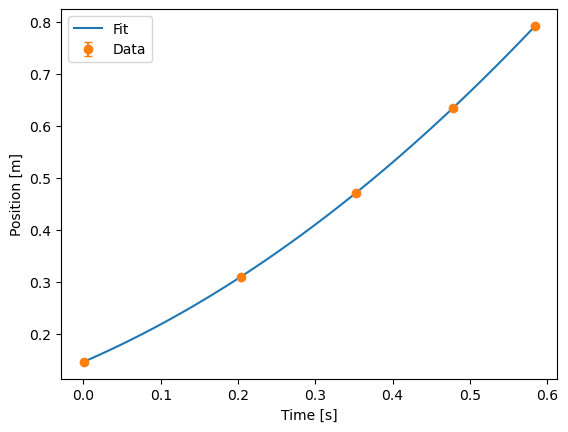

0.9088729168717176
[5.73512256e-04 2.03835664e-01 3.52062568e-01 4.77119428e-01
 5.83558416e-01]
[3.67201993e-05 7.27248448e-05 1.05384146e-04 1.05384146e-04
 1.41371363e-04]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.07461 (χ²/ndof = 0.0)    │              Nfcn = 78               │
│ EDM = 9.61e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.585   │   0.013   │            │            │         │         │       │
│ 1 │ v0   │   0.644   │   0.004   │            │            │         │         │       │
│ 2 │ x0   │ 145.6e-3  │  0.5e-3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │         a        v0        x0 │
├────┼───────────────────────────────┤
│  a │  0.000168 -0.048e-3   3.26e-6 │
│ v0 │ -0.048e-3   1.5e-05  -1.33e-6 │
│ x0 │   3.26e-6  -1.33e-6  2.41e-07 │
└────┴───────────────────────────────┘

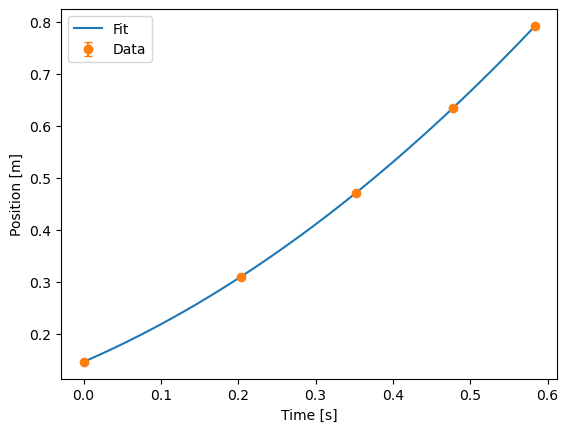

0.9633822589462016
<ValueView a=1.5828523668639978 v0=0.6427862958033319 x0=0.14564132215271974> <ErrorView a=0.013258301374998671 v0=0.00394559531565251 x0=0.000491448284834828>
<ValueView a=1.584883273069742 v0=0.6435124186507403 x0=0.14562176310600466> <ErrorView a=0.012976229002859128 v0=0.0038721777863482874 x0=0.000490439095405527>


In [34]:
val, err = peak_fit('dataproject\\incline_data', np.mean(xset,axis = 0), x_err= np.array([0.0005]*5))
const_prob = stats.chi2.sf(0.1911, 2)
print(const_prob)
valr, err_r = peak_fit('dataproject\\incline_rev_data', np.mean(xset,axis = 0), x_err= np.array([0.0005]*5))
const_prob = stats.chi2.sf(0.07461, 2)
print(const_prob)
print(val, err)
print(valr, err_r)

## Goniometer

In [35]:
np.mean(theta_list_incline)*180/np.pi

14.883333333333331

In [36]:
# incline
g_err(val[0],err[0],np.mean(theta_list_incline), 0.2*np.pi/180, 0,0, np.mean(Dlist), 0.01*10**(-3), np.mean(dlist), 0.01*10**(-3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

a  0.07917424144613891
v  -0.12414840988356768
ve  -0.0
D  -0.0018577330053845865
d  0.003710247659630454


<IPython.core.display.Latex object>

(9.452276873416235, 0.14730446461260063)

In [37]:
np.mean(theta_list_inclinerev)*180/np.pi

14.716666666666667

In [38]:
# reverse incline
g_err(valr[0],err_r[0],np.mean(theta_list_inclinerev), 0.2*np.pi/180, 0,0, np.mean(Dlist), 0.01*10**(-3), np.mean(dlist), 0.01*10**(-3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

a  0.07834765806861367
v  -0.127172966489006
ve  -0.0
D  -0.0018807092583385504
d  0.0037561356255019947


<IPython.core.display.Latex object>

(9.569181672870746, 0.14942879425533023)

## Trig

In [39]:
delta_theta = (val[0]-valr[0])*np.sin(np.mean(theta_list_trig))/(val[0]+valr[0])*1/np.cos(np.mean(theta_list_trig))
print(delta_theta)
delta_theta_err2(val[0],err[0],valr[0],err_r[0],np.mean(theta_list_trig), 0.001178994461)

-0.00016704439517663196


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

P = (-0.0 ± 0.0) m/s²


(-0.00016704439517663193, 0.0015259193372643125)

In [40]:
0.00016704439517663193*180/np.pi

0.009570938834936496

In [41]:
0.001178994*180/np.pi
np.mean(theta_list_trig)*180/np.pi

14.603726173199702

In [42]:
g_err(valr[0],err_r[0],np.mean(theta_list_trig), 0.001178994, 0.0001,0.0015, np.mean(Dlist), 0.01*10**(-3), np.mean(dlist), 0.01*10**(-3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

a  0.07890995702104264
v  -0.04359365092582245
ve  -0.05546294246513017
D  -0.0018942070561267256
d  0.0037830933059160186


<IPython.core.display.Latex object>

(9.637859422313436, 0.10593028613351492)

In [43]:
g_err(val[0],err[0],np.mean(theta_list_trig), 0.001178994, 0.0001,0.0015, np.mean(Dlist), 0.01*10**(-3), np.mean(dlist), 0.01*10**(-3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

a  0.08062527190624161
v  -0.043537789009868974
ve  -0.05539187096355321
D  -0.001891779775247042
d  0.0037782455623613692


<IPython.core.display.Latex object>

(9.625509245588463, 0.10715450004975866)

In [44]:
g_list = np.array([9.63,9.57,9.45])
g_err_list = np.array([0.11,0.15,0.15])
# weighted average
g = np.sum(g_list/g_err_list**2)/np.sum(1/g_err_list**2)
g_err = 1/np.sqrt(np.sum(1/g_err_list**2))
print(g,g_err)

9.567815845824411 0.07635289420815335


In [45]:
g_list = np.array([9.63,9.57,9.45,9.8217])
g_err_list = np.array([0.11,0.15,0.15,0.0047])
# weighted average
g = np.sum(g_list/g_err_list**2)/np.sum(1/g_err_list**2)
g_err = 1/np.sqrt(np.sum(1/g_err_list**2))
print(g,g_err)

9.820741619881378 0.004691120663901294


In [46]:
g_list = np.array([9.56,9.8217])
g_err_list = np.array([0.08,0.0047])
# weighted average
g = np.sum(g_list/g_err_list**2)/np.sum(1/g_err_list**2)
g_err = 1/np.sqrt(np.sum(1/g_err_list**2))
print(g,g_err)

9.820799833076148 0.004691909765075156


In [47]:
np.abs(9.56-9.8217)/np.sqrt(0.08**2 + 0.0047**2)

3.2656191104259724

In [48]:
(0.002)/np.sqrt(0.013**2 + 0.013**2)

0.10878565864408424

In [50]:
g_list = np.array([9.63,9.57,9.45])
g_err_list = np.array([0.11,0.15,0.15])
g = np.sum(g_list/g_err_list**2)/np.sum(1/g_err_list**2)
g_err = 1/np.sqrt(np.sum(1/g_err_list**2))
chi2 = np.sum((g_list-g)**2/g_err_list**2)
print(chi2)

0.936702355460401
